# Measuring the fading memory property of an ESN reservoir

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 15
# plt.rcParams['legend.fontsize'] = 12

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12



In [2]:
class EchoStateNetwork:

  def __init__(self, *, in_size, res_size, leak_rate, random_seed=42, X_init=None):
    self.in_size = in_size
    self.res_size = res_size
    self.leak_rate = leak_rate
    self.seed = random_seed
    self.bias_in = None
    self.W_in = None
    self.W_res = None
    self.X_init = X_init
    self._init_reservoir()

  def _init_reservoir(self):
    # partially based on https://mantas.info/wp/wp-content/uploads/simple_esn/minimalESN.py
    np.random.seed(self.seed)
    self.W_in = np.random.rand(self.res_size, self.in_size) - 0.5
    self.bias_in = np.random.rand() - 0.5
    self.W_res = np.random.rand(self.res_size, self.res_size) - 0.5 

    # normalizing and setting spectral radius (correct, slow):
    print('Computing spectral radius...')
    rhoW = max(abs(np.linalg.eig(self.W_res)[0]))
    print('done.')
    self.W_res *= 1.25 / rhoW

    # Generating the initial reservoir
    if self.X_init is None:
      self.X_init = np.zeros(self.res_size)
    else:
      assert len(X_init) == self.res_size

  
  def feed_input(self, u):
    assert len(u.shape) == 2
    assert u.shape[1] == self.in_size

    X_hist = np.empty((len(u) + 1, *self.X_init.shape))
    X_hist[0] = self.X_init

    for i in range(len(u)):
      X_step = self.bias_in + self.W_in @ u[i] + self.W_res @ X_hist[i]
      X_step = np.tanh(X_step)
      X_step = (1 - self.leak_rate) * X_hist[i] + self.leak_rate * X_step
      X_hist[i+1] = X_step

    return X_hist


model = EchoStateNetwork(in_size=1, res_size=100, leak_rate=0.3)

Computing spectral radius...
done.


In [3]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True)

print(X.shape, y.shape)

(20640, 8) (20640,)


In [4]:
model = EchoStateNetwork(in_size=X.shape[1], res_size=100, leak_rate=0.3, random_seed=42)

in_series = X[:1000]

reservoir_hist = model.feed_input(in_series)

print(reservoir_hist.shape)

Computing spectral radius...
done.
(1001, 100)


## Effect of starting conditions

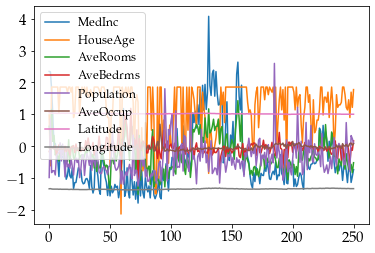

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler


X, y = fetch_california_housing(return_X_y=True, as_frame=True)

scaler = StandardScaler()
for col in X.columns:
  X[[col]] = scaler.fit_transform(X[[col]])

in_series = X.to_numpy()[:1000]

X.loc[:250, :].plot()
plt.show()

Computing spectral radius...
done.
(4, 251)


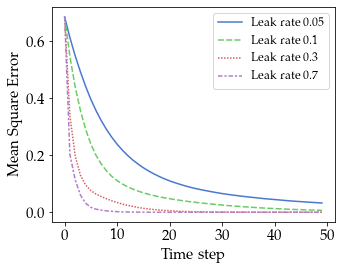

In [6]:
RES_SIZE = 100
INPUT_LEN = 250
LEAK_RATES = [0.05, 0.1, 0.3, 0.7]

# setup
in_series = X.to_numpy()[:INPUT_LEN]
model = EchoStateNetwork(in_size=in_series.shape[1], res_size=RES_SIZE, leak_rate=0.1, random_seed=42)
X_init_0 = (np.random.rand((RES_SIZE)) * 2) - 1
X_init_1 = (np.random.rand((RES_SIZE)) * 2) - 1
reservoirs = [X_init_0, X_init_1]


# execution
distances = np.empty((len(LEAK_RATES), INPUT_LEN + 1))
for i, leak_rate in enumerate(LEAK_RATES):
  X_hists = []
  for X_init in reservoirs:
    model.X_init = X_init
    model.leak_rate = leak_rate
    X_hist = model.feed_input(in_series)
    X_hists.append(X_hist)
  hist0, hist1 = X_hists
  distances[i] = np.mean((hist0 - hist1)**2, axis=1)

dist_df = pd.DataFrame(distances.T, columns=[f'Leak rate {lr}' for lr in LEAK_RATES])


# comparison of trajectories
print(distances.shape)
with plt.style.context('seaborn-muted'):
  fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=False)
  # ax.plot(distances.T[:50], label=LEAK_RATES)
  sns.lineplot(data=dist_df.iloc[:50], ax=ax)
  # ax.legend(title='ESN leak rate')
  ax.set_xlabel('Time step')
  ax.set_ylabel('Mean Square Error')
  plt.tight_layout()
  plt.savefig('esn_starting_conditions.png', dpi=200, facecolor='white')
  plt.show()

## Effect of impulse

Computing spectral radius...
done.
(4, 251)


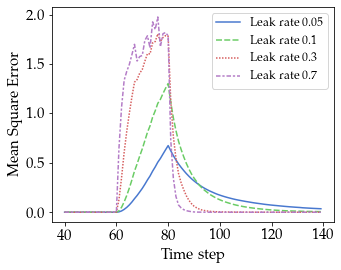

In [7]:
RES_SIZE = 100
INPUT_LEN = 250
LEAK_RATES = [0.05, 0.1, 0.3, 0.7]

# setup
in_series_control = X.to_numpy()[:INPUT_LEN]
in_series_impulse = np.array(in_series_control, copy=True)
in_series_impulse[60:80, :] = 10
inputs = [in_series_control, in_series_impulse]

model = EchoStateNetwork(in_size=in_series_control.shape[1], res_size=RES_SIZE, leak_rate=0.1, random_seed=42)
X_init = (np.random.rand((RES_SIZE)) * 2) - 1

# execution
distances = np.empty((len(LEAK_RATES), INPUT_LEN + 1))
for i, leak_rate in enumerate(LEAK_RATES):
  X_hists = []
  for in_series in inputs:
    model.X_init = X_init
    model.leak_rate = leak_rate
    X_hist = model.feed_input(in_series)
    X_hists.append(X_hist)
  hist0, hist1 = X_hists
  distances[i] = np.mean((hist0 - hist1)**2, axis=1)

dist_df = pd.DataFrame(distances.T, columns=[f'Leak rate {lr}' for lr in LEAK_RATES])

# comparison of trajectories
print(distances.shape)
with plt.style.context('seaborn-muted'):
  fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=False)
  sns.lineplot(data=dist_df.iloc[40:140], ax=ax)
  # ax.plot(np.arange(40, 140), distances.T[40:140], label=LEAK_RATES)
  # ax.legend(title='ESN leak rate')
  ax.set_xlabel('Time step')
  ax.set_ylabel('Mean Square Error')
  plt.tight_layout()
  plt.savefig('esn_impulse.png', dpi=200, facecolor='white')
  plt.show()



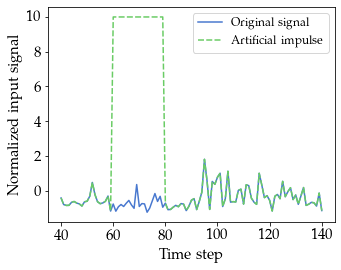

In [8]:
X_plot, _ = fetch_california_housing(return_X_y=True, as_frame=True)

scaler = StandardScaler()
for col in X.columns:
  X_plot[[col]] = scaler.fit_transform(X[[col]])


with plt.style.context('seaborn-muted'):
  fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=False)
  data = X_plot.loc[40:140].copy()
  data['impulse'] = data['Population']
  data['impulse'][60 - 40:80 - 40] = 10
  sns.lineplot(data=data[['Population', 'impulse']], ax=ax)

  ax.legend(labels=['Original signal', 'Artificial impulse'], loc='upper right')
  ax.set_xlabel('Time step')
  ax.set_ylabel('Normalized input signal')
  plt.tight_layout()
  plt.savefig('input_impulse.png', dpi=200, facecolor='white')